In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import pandas as pd
import requests, io

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
# Read data
url = 'https://github.com/posaeidon/DeepLearning-ASA/blob/master/data/DLA_A1_data/obs_matrix.npy?raw=true'
s=requests.get(url, stream=True).content
obs_matrix = pd.DataFrame(np.load(io.BytesIO(s)))

url = 'https://github.com/posaeidon/DeepLearning-ASA/blob/master/data/DLA_A1_data/pho_matrix.npy?raw=true'
s=requests.get(url, stream=True).content
pho_matrix = pd.DataFrame(np.load(io.BytesIO(s)))

url = 'https://github.com/posaeidon/DeepLearning-ASA/blob/master/data/DLA_A1_data/sim_matrix.npy?raw=true'
s=requests.get(url, stream=True).content
sim_matrix = pd.DataFrame(np.load(io.BytesIO(s)))

In [3]:
# drop designation number for asteroid
obs = obs_matrix.drop(5, axis=1)
pho = pho_matrix.drop(5, axis=1)
sim = sim_matrix.drop(5, axis=1)

In [4]:
# label 0 for non hazardous planetaries and 1 for hazardous planetaries
obs_labels = pd.Series(np.zeros(obs.shape[0]))
obs[5] = obs_labels 

sim_labels = pd.Series(np.ones(sim.shape[0]))
sim[5] = sim_labels 

data = pd.concat([obs, sim])

In [5]:
# Prepare data
X = np.array(data.drop(5, axis=1))
Y = np.array(data[5])

from sklearn.utils import shuffle
X, Y = shuffle(X,Y, random_state = 0)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0, test_size=0.10)

In [6]:
# Define model
model = keras.Sequential([
    keras.layers.Dense(4, activation="relu"),
    keras.layers.Dense(2, activation="softmax")
])

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.build((None, 5))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  24        
_________________________________________________________________
dense_1 (Dense)              multiple                  10        
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Fit modell and record history
history = model.fit(X_train, Y_train, validation_split=0.25, epochs=30, batch_size=32, verbose=1)

Train on 711610 samples, validate on 237204 samples
Epoch 1/30
711610/711610 [==============================] - 26s 36us/sample - loss: 0.0916 - acc: 0.9744 - val_loss: 0.0627 - val_acc: 0.9799
Epoch 2/30
711610/711610 [==============================] - 25s 35us/sample - loss: 0.0574 - acc: 0.9817 - val_loss: 0.0567 - val_acc: 0.9814
Epoch 3/30
711610/711610 [==============================] - 25s 35us/sample - loss: 0.0544 - acc: 0.9826 - val_loss: 0.0558 - val_acc: 0.9821
Epoch 4/30
711610/711610 [==============================] - 25s 36us/sample - loss: 0.0534 - acc: 0.9828 - val_loss: 0.0543 - val_acc: 0.9831
Epoch 5/30
711610/711610 [==============================] - 25s 36us/sample - loss: 0.0527 - acc: 0.9828 - val_loss: 0.0542 - val_acc: 0.9830
Epoch 6/30
711610/711610 [==============================] - 26s 36us/sample - loss: 0.0525 - acc: 0.9830 - val_loss: 0.0537 - val_acc: 0.9833
Epoch 7/30
711610/711610 [==============================] - 26s 36us/sample - loss: 0.0522 - acc

In [8]:
# Evaluate model with unused test data
result = model.evaluate(X_test, Y_test, verbose=0)
print ("The loss on the test data was: ", result[0])
print ("The accuracy on the test data was: ", result[1])

The loss on the test data was:  0.05099102081300919
The accuracy on the test data was:  0.983315


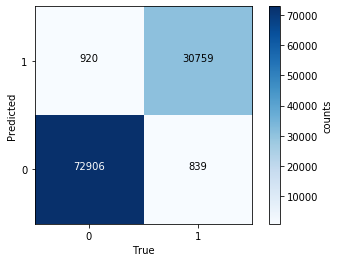

In [9]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix
Y_predicted = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(Y_test, Y_predicted)

# Plot confusion matrix
fig = plt.figure(1)
ax = fig.add_subplot(111)

cax = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
fig.colorbar(cax, label='counts')

ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, 1.5)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])

for i in range(2):
	for j in range(2):
		if cm[i,j] > np.max(cm)/2.:
			c="white"
		else:
			c="black"
		ax.text(j, i, str(cm[i,j]), horizontalalignment='center', color=c)

ax.set_ylabel('Predicted')
ax.set_xlabel('True')

plt.savefig('cm.png')

In [10]:
# Check how many are hitting to compare if confusion matrix makes sense
print('Hitting percentage in train data:', sum(Y_train)/len(Y_train))
print('Hitting percentage in test data:', sum(Y_test)/len(Y_test))

Hitting percentage in train data: 0.30182733391370703
Hitting percentage in test data: 0.30049134921839427


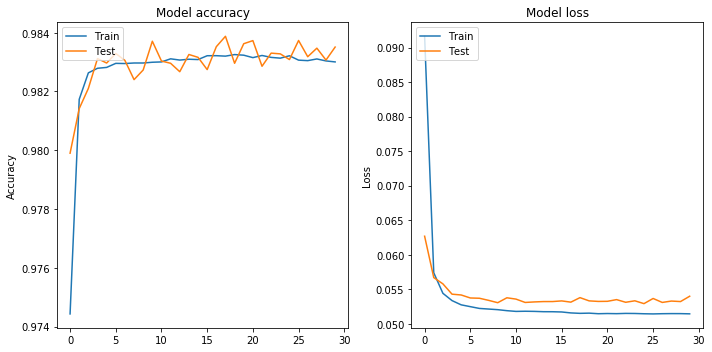

In [11]:
# Plot training & validation accuracy values
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, title = 'Model accuracy', ylabel= 'Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
ax = fig.add_subplot(1,2,2, title = 'Model loss', ylabel= 'Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

fig.savefig('model_acc_loss.png')

(array([599.,  94.,  73.,  61.,  55.,  62.,  61.,  65., 116., 567.]),
 array([4.29137508e-05, 1.00038625e-01, 2.00034335e-01, 3.00030053e-01,
        4.00025755e-01, 5.00021458e-01, 6.00017190e-01, 7.00012863e-01,
        8.00008595e-01, 9.00004268e-01, 1.00000000e+00], dtype=float32),
 <a list of 10 Patch objects>)

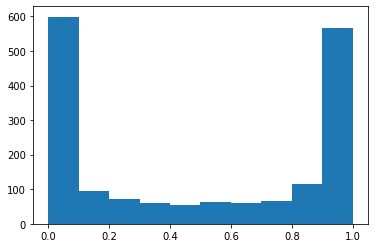

In [12]:
# Prepare pho matrix and plot histogram
pho_test = np.array(pho)
plt.hist(model.predict(pho_test)[:, 1])

(array([882., 871.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

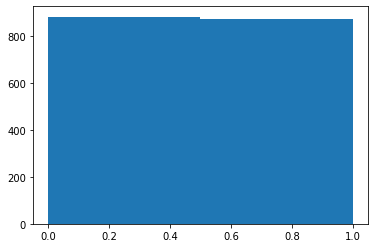

In [13]:
# Change percentage value to integer 0 or 1 and plot histogram
pho_predict = np.argmax(model.predict(pho_test), axis=1)
plt.hist(pho_predict, bins=2)

(array([727849.,   8332.]),
 array([0. , 0.5, 1. ]),
 <a list of 2 Patch objects>)

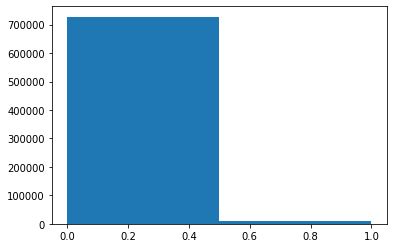

In [14]:
# Also test elements of observed matrix and plot histogram
obs_test = np.array(obs_matrix.drop(5, axis=1))
predict_obs = np.argmax(model.predict(obs_test), axis=1)
plt.hist(predict_obs, bins=2)

(array([  9040., 309017.]),
 array([0. , 0.5, 1. ]),
 <a list of 2 Patch objects>)

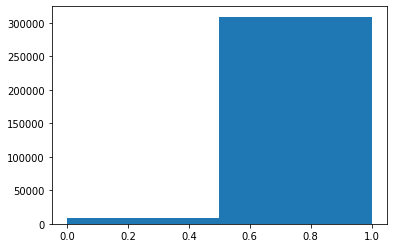

In [15]:
# And test sim matrix and plot histogram
sim_test = np.array(sim_matrix.drop(5, axis=1))
predict_sim = np.argmax(model.predict(sim_test), axis=1)
plt.hist(predict_sim, bins=2)

In [16]:
# Extract and save hitting and non hitting from obs
predict = pd.Series(predict_obs)
ho_obs = obs_matrix.iloc[predict[predict == 1].index]
nho_obs = obs_matrix.iloc[predict[predict == 0].index]

np.savetxt(r'ho_obs.txt', ho_obs[5].values, fmt='%d')
np.savetxt(r'nho_obs.txt', nho_obs[5].values, fmt='%d')

In [17]:
# Extract and save hitting and non hitting from pho
predict = pd.Series(pho_predict)
ho_pho = pho_matrix.iloc[predict[predict == 1].index] #hazardous objects
nho_pho = pho_matrix.iloc[predict[predict == 0].index] #non hazardous objects

np.savetxt(r'ho_pho.txt', ho_pho[5].values, fmt='%d')
np.savetxt(r'nho_pho.txt', nho_pho[5].values, fmt='%d')

In [19]:
# Create files with 1000 predicted hazardous and 1000 predicted non hazardous
if len(ho_pho) > 1000:
  ho1000 = ho_pho[:1000]
else:
  n_remaining = 1000 - len(ho_pho)
  ho1000 = pd.concat([ho_pho, ho_obs[:n_remaining]])
  
if len(nho_pho) > 1000:
  nho1000 = nho_pho[:1000]
else:
  n_remaining = 1000 - len(nho_pho)
  nho1000 = pd.concat([nho_pho, nho_obs[:n_remaining]])

np.savetxt(r'ho1000.txt', ho1000[5].values, fmt='%d')
np.savetxt(r'nho1000.txt', nho1000[5].values, fmt='%d')